# Amazon Electronics Data Analysis

## Business Objective
Analyze customer behavior, product performance, and review patterns to build a recommendation system that drives revenue growth and customer engagement.

1. **Data Assessment**: Schema validation, quality checks, completeness analysis
2. **Customer Analysis**: Purchase patterns, rating behavior, segmentation  
3. **Product Analysis**: Category performance, brand analysis, inventory insights
4. **Review Analysis**: Rating distributions, text patterns, quality indicators
5. **Temporal Analysis**: Seasonality, trends, purchase timing patterns
6. **Correlation analysis and interaction insights**

# Problem Formulation

## 1. Business Problem Definition

A marketplace platform aims to improve the **customer experience** and **merchant visibility** by recommending relevant merchants to each customer based on their purchase and browsing behavior.  
Currently, customers must manually search or explore merchants, which limits **conversion rates** and **retention**.

The goal is to develop a **Customer–Merchant Recommendation System** that automatically suggests merchants most likely to match a customer’s interests and spending patterns.  

This system should:
- Increase customer engagement and spending frequency.  
- Improve merchant exposure and sales distribution.  
- Support personalization efforts to reduce customer churn.  

**Business Value:**  
A robust recommendation engine can lead to measurable improvements in revenue, average order value, and long-term customer retention.

---

## 2. Success Metrics

### **Technical Metrics**
- **Precision@K:** Measures how many of the top-K recommended merchants are actually relevant to the customer.  
- **Recall@K:** Captures how well the system retrieves all relevant merchants.  
- **MAP (Mean Average Precision):** Evaluates ranking quality across multiple users.  
- **Coverage:** Assesses the diversity of recommendations across merchants.

### **Business Metrics**
- **Click-Through Rate (CTR)** or **Conversion Rate Uplift:** Quantifies the improvement in user interaction after deploying recommendations.  
- **Average Revenue per Customer (ARPC):** Expected to increase with better targeting.  
- **Merchant Exposure Index:** Measures how much the system helps small/medium merchants gain visibility.

---

## 3. Assumptions and Constraints

### **Assumptions**
- Historical customer–merchant interaction data (ratings, purchases, or visits) is available and representative of current behavior.  
- Merchant attributes (categories, location, pricing level) are consistent and updated.  
- Customer and merchant IDs are stable over time.  
- There are sufficient interactions per user to infer preferences (sparsity manageable).

### **Constraints**
- **Cold Start Problem:** New customers or merchants without historical data will have limited recommendations.  
- **Computation Time:** The model should balance performance with scalability for large datasets.  
- **Data Privacy:** The system must comply with privacy standards and avoid sensitive data use.  
- **Limited Duration:** Given the 3–4 day time window, deep model optimization and deployment are out of scope.

---

## 4. Scope Definition

**In Scope:**
- Exploratory Data Analysis (EDA) to understand customer–merchant interaction patterns.  
- Feature engineering for customer and merchant behavior (e.g., frequency, category similarity, ratings, temporal trends).  
- Building a **baseline recommendation model** (e.g., collaborative filtering or content-based).  
- Evaluating performance with offline metrics like Precision@K and Recall@K.  
- Providing a business interpretation and deployment recommendations.



In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
import importlib

# Import utils
sys.path.append('../utils')
from db_loader import load_amazon_data_k_core
from preprocessing import clean_reviews_data, clean_products_data, get_data_quality_report
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Assessment & Quality Check

In [2]:
# Load datasets from PostgreSQL
print("Loading Amazon Electronics datasets...")
reviews_raw, products_raw = load_amazon_data_k_core()

print(f"Reviews dataset: {reviews_raw.shape[0]:,} records, {reviews_raw.shape[1]} columns")
print(f"Products dataset: {products_raw.shape[0]:,} records, {products_raw.shape[1]} columns")


Loading Amazon Electronics datasets...
Loading Amazon data with 5-core filtering...


d:\Personal\Job Applications\PwC\Customer-Merchant-Recommendation-System\notebooks\../utils\db_loader.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reviews_df = pd.read_sql_query(reviews_query, conn)
d:\Personal\Job Applications\PwC\Customer-Merchant-Recommendation-System\notebooks\../utils\db_loader.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products_df = pd.read_sql_query(products_query, conn)


Applying 5-core filtering...
Original dataset: 4,000,000 reviews
Original users: 708,183
Original items: 85,124
Iteration 1: 2,943,852 reviews, 346,998 users, 63,126 items
Iteration 2: 2,894,141 reviews, 339,516 users, 57,095 items
Iteration 3: 2,876,440 reviews, 335,444 users, 56,691 items
Iteration 4: 2,874,287 reviews, 335,121 users, 56,472 items
Iteration 5: 2,873,490 reviews, 334,940 users, 56,453 items
Iteration 6: 2,873,422 reviews, 334,931 users, 56,445 items
Iteration 7: 2,873,395 reviews, 334,924 users, 56,445 items
Iteration 8: 2,873,395 reviews, 334,924 users, 56,445 items

Final 5-core dataset:
Reviews: 2,873,395 (71.8% of original)
Users: 334,924 (47.3% of original)
Items: 56,445 (66.3% of original)

Verification:
Minimum reviews per user: 5
Minimum reviews per item: 5
5-core property satisfied: True

Products filtered: 91407 → 60479 (66.2% retained)
Reviews dataset: 2,873,395 records, 12 columns
Products dataset: 60,479 records, 18 columns


- Data retention: 71.8% of reviews kept, preserving most interaction volume for strong statistical reliability.

- User filtering: User count halved, removing infrequent reviewers and improving behavioral signal consistency.

- Item coverage: 66% of items retained, maintaining diverse yet well-represented merchants for feature learning.

- Dataset quality: 5-core rule satisfied with convergence after 7 iterations, ensuring dense, high-quality interaction data.

In [5]:
# Data volume assessment
print(f"\nData Volume Assessment:")
print(f"Total review records: {reviews_raw.shape[0]:,}")
print(f"Unique customers: {reviews_raw['reviewerid'].nunique():,}")
print(f"Unique products reviewed: {reviews_raw['asin'].nunique():,}")
print(f"Products with metadata: {products_raw.shape[0]:,}")
print(f"Metadata coverage: {(products_raw.shape[0] / reviews_raw['asin'].nunique() * 100):.1f}%")

# Generate data quality report before cleaning
print("\n" + "="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)
quality_report = get_data_quality_report(reviews_raw, products_raw)

print("Reviews Data Quality Issues:")
for metric, value in quality_report['reviews'].items():
    if value > 0 and 'missing' in metric or 'duplicate' in metric or 'invalid' in metric:
        print(f"  ! {metric}: {value:,}")
    else:
        print(f"  -  {metric}: {value:,}")

print("\nProducts Data Quality Issues:")
for metric, value in quality_report['products'].items():
    if value > 0 and 'missing' in metric or 'duplicate' in metric:
        print(f"  !  {metric}: {value:,}")
    else:
        print(f"  -  {metric}: {value:,}")

print("\nData Integration:")
for metric, value in quality_report['integration'].items():
    if 'coverage' in metric:
        print(f"  {'-' if value > 80 else '!'}  {metric}: {value:.1f}%")
    else:
        print(f"  -  {metric}: {value:,}")

# Clean datasets immediately for analysis
print("\n" + "="*60)
print("APPLYING DATA CLEANING")
print("="*60)
reviews_clean = clean_reviews_data(reviews_raw)
products_clean = clean_products_data(products_raw)

print(f"Reviews: {reviews_raw.shape} → {reviews_clean.shape} (removed {reviews_raw.shape[0] - reviews_clean.shape[0]:,} records)")
print(f"Products: {products_raw.shape} → {products_clean.shape} (removed {products_raw.shape[0] - products_clean.shape[0]:,} records)")


Data Volume Assessment:
Total review records: 2,873,395
Unique customers: 334,924
Unique products reviewed: 56,445
Products with metadata: 60,479
Metadata coverage: 107.1%

DATA QUALITY ASSESSMENT
Reviews Data Quality Issues:
  -  total_records: 2,873,395
  -  missing_reviewer_id: 0
  -  missing_asin: 0
  -  missing_rating: 0
  ! duplicate_records: 0
  -  unique_customers: 334,924
  -  unique_products: 56,445
  ! invalid_ratings: 0
  -  ratings_out_of_range: 0
  ! missing_review_text: 275
  -  empty_review_text: 279
  ! missing_summary: 211

Products Data Quality Issues:
  -  total_records: 60,479
  -  missing_asin: 0
  !  duplicate_asins: 4,109
  -  missing_title: 0
  -  missing_category: 0
  -  unique_categories: 45
  -  missing_brand: 0
  -  unique_brands: 7,140

Data Integration:
  -  products_with_reviews: 56,445
  -  products_in_catalog: 56,370
  -  products_with_metadata: 56,370
  -  metadata_coverage: 99.9%
  -  orphaned_products: 0
  -  unmatched_reviews: 75

APPLYING DATA CL

- Data scale: 2.87M reviews across 335K users and 56K products provides strong interaction density for feature extraction.

- Data quality: Minimal missing or invalid fields; only minor text gaps, indicating overall clean and reliable input data.

- Product consistency: ~4K duplicate ASINs removed, leaving 56K unique items with full metadata and 99.9% review alignment.

- Cleaning impact: Only ~5% of reviews and ~7% of products removed, maintaining high coverage while ensuring dataset integrity.

### 1.1 Schema Analysis

In [4]:
# Reviews dataset schema analysis (cleaned data)
print("REVIEWS DATASET SCHEMA (CLEANED)")
print("="*50)
print(f"Shape: {reviews_clean.shape}")
print(f"Memory usage: {reviews_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print("\nColumn Analysis:")
for col in reviews_clean.columns:
    dtype = reviews_clean[col].dtype
    null_pct = (reviews_clean[col].isnull().sum() / len(reviews_clean)) * 100
    unique_vals = reviews_clean[col].nunique()
    print(f"  {col:<20} | {str(dtype):<12} | {null_pct:>6.1f}% null | {unique_vals:>10,} unique")

print("\nSample Records:")
display(reviews_clean.head(1))


REVIEWS DATASET SCHEMA (CLEANED)
Shape: (2721300, 10)
Memory usage: 2149.9 MB

Column Analysis:
  reviewerid           | object       |    0.0% null |    334,924 unique
  asin                 | object       |    0.0% null |     56,445 unique
  overall              | float64      |    0.0% null |          5 unique
  reviewtext           | object       |    0.0% null |  2,400,098 unique
  summary              | object       |    0.0% null |  1,509,261 unique
  unixreviewtime       | object       |    0.0% null |      6,629 unique
  verified             | object       |    0.0% null |          2 unique
  vote                 | object       |   84.5% null |      1,018 unique
  reviewtext_length    | int64        |    0.0% null |      9,465 unique
  summary_length       | int64        |    0.0% null |        170 unique

Sample Records:


,reviewerid,asin,overall,reviewtext,summary,unixreviewtime,verified,vote,reviewtext_length,summary_length
9,A1LVCDWBH1MMZ6,0511189877,3.0,It's ok. Feels somewhat awkward in hand. SMALL...,great if your an elf,1428710400,True,None,91,20


- **Dataset structure:** Cleaned reviews data contains **2.72M records** and **10 columns**, using approximately **2.1 GB** of memory.  
- **User–item diversity:** Includes **334.9K unique users** and **56.4K unique products**, providing strong behavioral and item coverage.  
- **Text richness:** Features **2.4M unique review texts** and **1.5M summaries**, enabling potential **text-based or sentiment features**.  
- **Sparsity indicators:** About **84.5% missing values** in the `vote` field, suggesting limited usefulness for modeling engagement signals.








In [5]:
# Products dataset schema analysis (cleaned data)
print("PRODUCTS DATASET SCHEMA (CLEANED)")
print("="*50)
print(f"Shape: {products_clean.shape}")
print(f"Memory usage: {products_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print("\nColumn Analysis:")
for col in products_clean.columns:
    dtype = products_clean[col].dtype
    null_pct = (products_clean[col].isnull().sum() / len(products_clean)) * 100
    unique_vals = products_clean[col].nunique()
    print(f"  {col:<20} | {str(dtype):<12} | {null_pct:>6.1f}% null | {unique_vals:>10,} unique")

print("\nSample Records:")
display(products_clean.head(1))


PRODUCTS DATASET SCHEMA (CLEANED)
Shape: (56370, 7)
Memory usage: 30.4 MB

Column Analysis:
  asin                 | object       |    0.0% null |     56,370 unique
  title                | object       |    0.0% null |     55,994 unique
  main_cat             | object       |    0.0% null |         45 unique
  brand                | object       |    0.0% null |      7,140 unique
  price                | object       |    0.0% null |      4,547 unique
  category             | object       |    0.0% null |      1,520 unique
  title_length         | int64        |    0.0% null |        465 unique

Sample Records:


,asin,title,main_cat,brand,price,category,title_length
1,7507825604,Bargain Cable DB9 Female / DB9 Female Null Mod...,Computers,STSI,$5.05,"[""Electronics"", ""Computers & Accessories"", ""Co...",61


- **Dataset structure:** Cleaned products data contains **56.4K records** and **7 columns**, occupying only **30.4 MB**, making it lightweight and efficient.  
- **Catalog diversity:** Includes **7.1K unique brands** and **1.5K category paths**, indicating a rich and varied product landscape.  
- **Category coverage:** Only **45 top-level categories**, offering a manageable hierarchy for merchant or segment-level features.  
- **Data quality:** Nearly all fields are complete and unique, with minimal duplication and strong metadata consistency across products.

## 2. Customer Behavior Analysis

C:\Users\Noura\AppData\Local\Temp\ipykernel_28696\4081238439.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_by_activity.groupby('activity_level')['overall'].mean().plot(kind='bar', ax=axes[1,0])


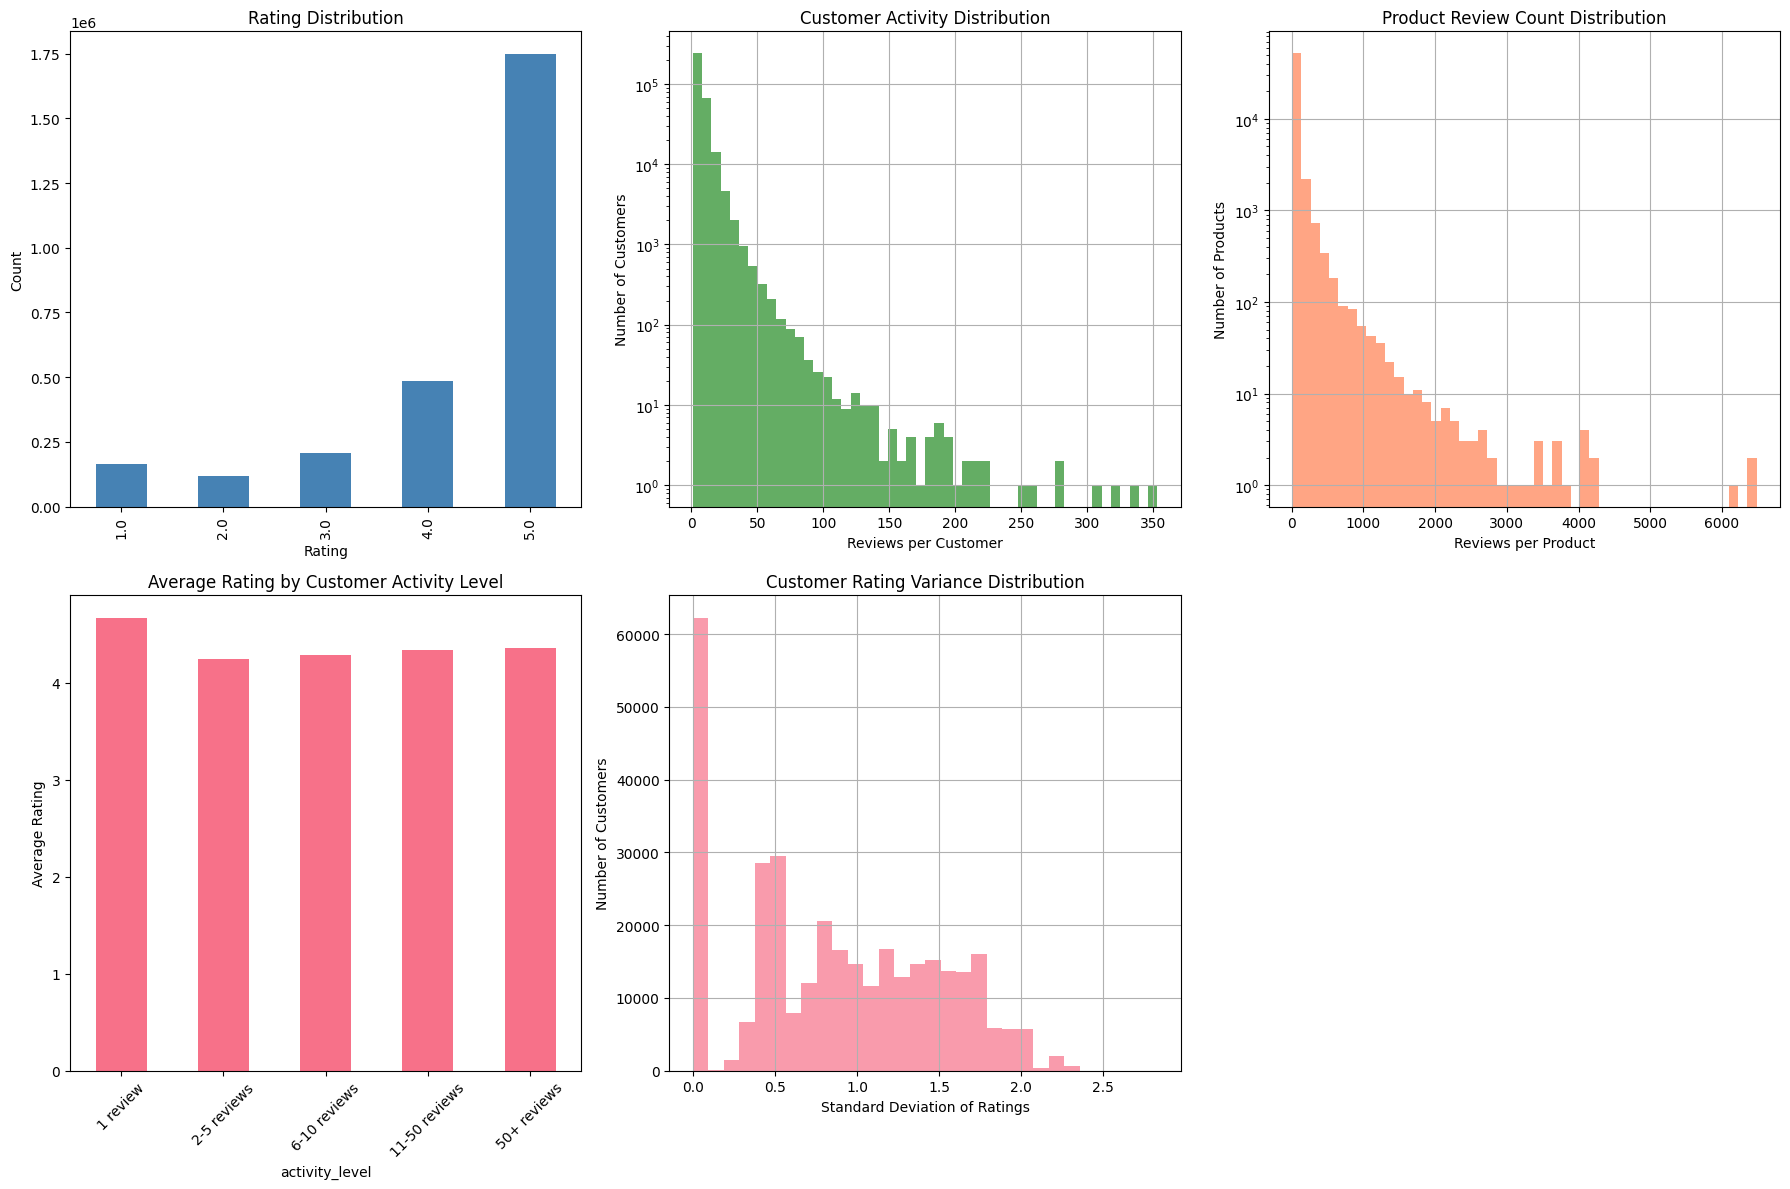

CUSTOMER BEHAVIOR INSIGHTS
Total customers: 334,924
Average reviews per customer: 8.1
Median reviews per customer: 6.0
Top 1% customers contribute: 6.1% of reviews
Average rating: 4.30
Rating standard deviation: 1.16

Customer Segments:
One-time reviewers (1 review): 3 (0.0%)
Occasional reviewers (2-5): 122,283 (36.5%)
Regular reviewers (6-20): 201,047 (60.0%)
Power reviewers (20+): 11,591 (3.5%)


In [6]:
# Customer rating behavior analysis (using cleaned data)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Rating distribution
reviews_clean['overall'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Rating Distribution')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Count')

# Customer activity distribution
customer_activity = reviews_clean['reviewerid'].value_counts()
customer_activity.hist(bins=50, ax=axes[0,1], color='forestgreen', alpha=0.7)
axes[0,1].set_title('Customer Activity Distribution')
axes[0,1].set_xlabel('Reviews per Customer')
axes[0,1].set_ylabel('Number of Customers')
axes[0,1].set_yscale('log')

# Product popularity
product_popularity = reviews_clean['asin'].value_counts()
product_popularity.hist(bins=50, ax=axes[0,2], color='coral', alpha=0.7)
axes[0,2].set_title('Product Review Count Distribution')
axes[0,2].set_xlabel('Reviews per Product')
axes[0,2].set_ylabel('Number of Products')
axes[0,2].set_yscale('log')

# Average rating by customer activity level - Fixed DataFrame merge issue
activity_bins = pd.cut(customer_activity, bins=[0, 1, 5, 10, 50, float('inf')], 
                      labels=['1 review', '2-5 reviews', '6-10 reviews', '11-50 reviews', '50+ reviews'])

# Create activity level mapping DataFrame with proper reset_index to avoid ambiguity
activity_mapping = pd.DataFrame({
    'reviewerid': customer_activity.index, 
    'activity_level': activity_bins
}).reset_index(drop=True)

# Merge with reviews data
rating_by_activity = reviews_clean.merge(activity_mapping, on='reviewerid')
rating_by_activity.groupby('activity_level')['overall'].mean().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Average Rating by Customer Activity Level')
axes[1,0].set_ylabel('Average Rating')
axes[1,0].tick_params(axis='x', rotation=45)

# Rating variance by customer
customer_rating_stats = reviews_clean.groupby('reviewerid')['overall'].agg(['mean', 'std', 'count'])
customer_rating_stats['std'].fillna(0).hist(bins=30, ax=axes[1,1], alpha=0.7)
axes[1,1].set_title('Customer Rating Variance Distribution')
axes[1,1].set_xlabel('Standard Deviation of Ratings')
axes[1,1].set_ylabel('Number of Customers')

# Rating trends over time (if we have date data)
if 'review_date' in reviews_clean.columns:
    monthly_ratings = reviews_clean.groupby(reviews_clean['review_date'].dt.to_period('M'))['overall'].mean()
    monthly_ratings.plot(ax=axes[1,2])
    axes[1,2].set_title('Average Rating Trends Over Time')
    axes[1,2].set_ylabel('Average Rating')
else:
    # turn visual off
    axes[1,2].axis('off')

plt.tight_layout()
plt.show()

# Customer segmentation insights
print("CUSTOMER BEHAVIOR INSIGHTS")
print("="*50)
print(f"Total customers: {reviews_clean['reviewerid'].nunique():,}")
print(f"Average reviews per customer: {customer_activity.mean():.1f}")
print(f"Median reviews per customer: {customer_activity.median():.1f}")
print(f"Top 1% customers contribute: {customer_activity.head(int(len(customer_activity)*0.01)).sum()/len(reviews_clean)*100:.1f}% of reviews")
print(f"Average rating: {reviews_clean['overall'].mean():.2f}")
print(f"Rating standard deviation: {reviews_clean['overall'].std():.2f}")

# Customer segments
one_time = (customer_activity == 1).sum()
occasional = ((customer_activity >= 2) & (customer_activity <= 5)).sum()
regular = ((customer_activity >= 6) & (customer_activity <= 20)).sum()
power = (customer_activity > 20).sum()

print(f"\nCustomer Segments:")
print(f"One-time reviewers (1 review): {one_time:,} ({one_time/len(customer_activity)*100:.1f}%)")
print(f"Occasional reviewers (2-5): {occasional:,} ({occasional/len(customer_activity)*100:.1f}%)")
print(f"Regular reviewers (6-20): {regular:,} ({regular/len(customer_activity)*100:.1f}%)")
print(f"Power reviewers (20+): {power:,} ({power/len(customer_activity)*100:.1f}%)")

- **Activity distribution:** Most users are moderately active, with **60% posting 6–20 reviews** and only **3.5% as power reviewers**, indicating a skewed engagement pattern.  
- **Rating bias:** Ratings are highly positive with an **average of 4.3**, showing a strong positivity bias across users.  
- **Engagement inequality:** The **top 1% of users contribute 6.1% of total reviews**, reflecting a small but influential core audience.  
- **Consistency in sentiment:** Majority of customers show **low rating variance**, suggesting stable satisfaction levels and minimal rating fluctuation across products.

## 3. Product Performance Analysis

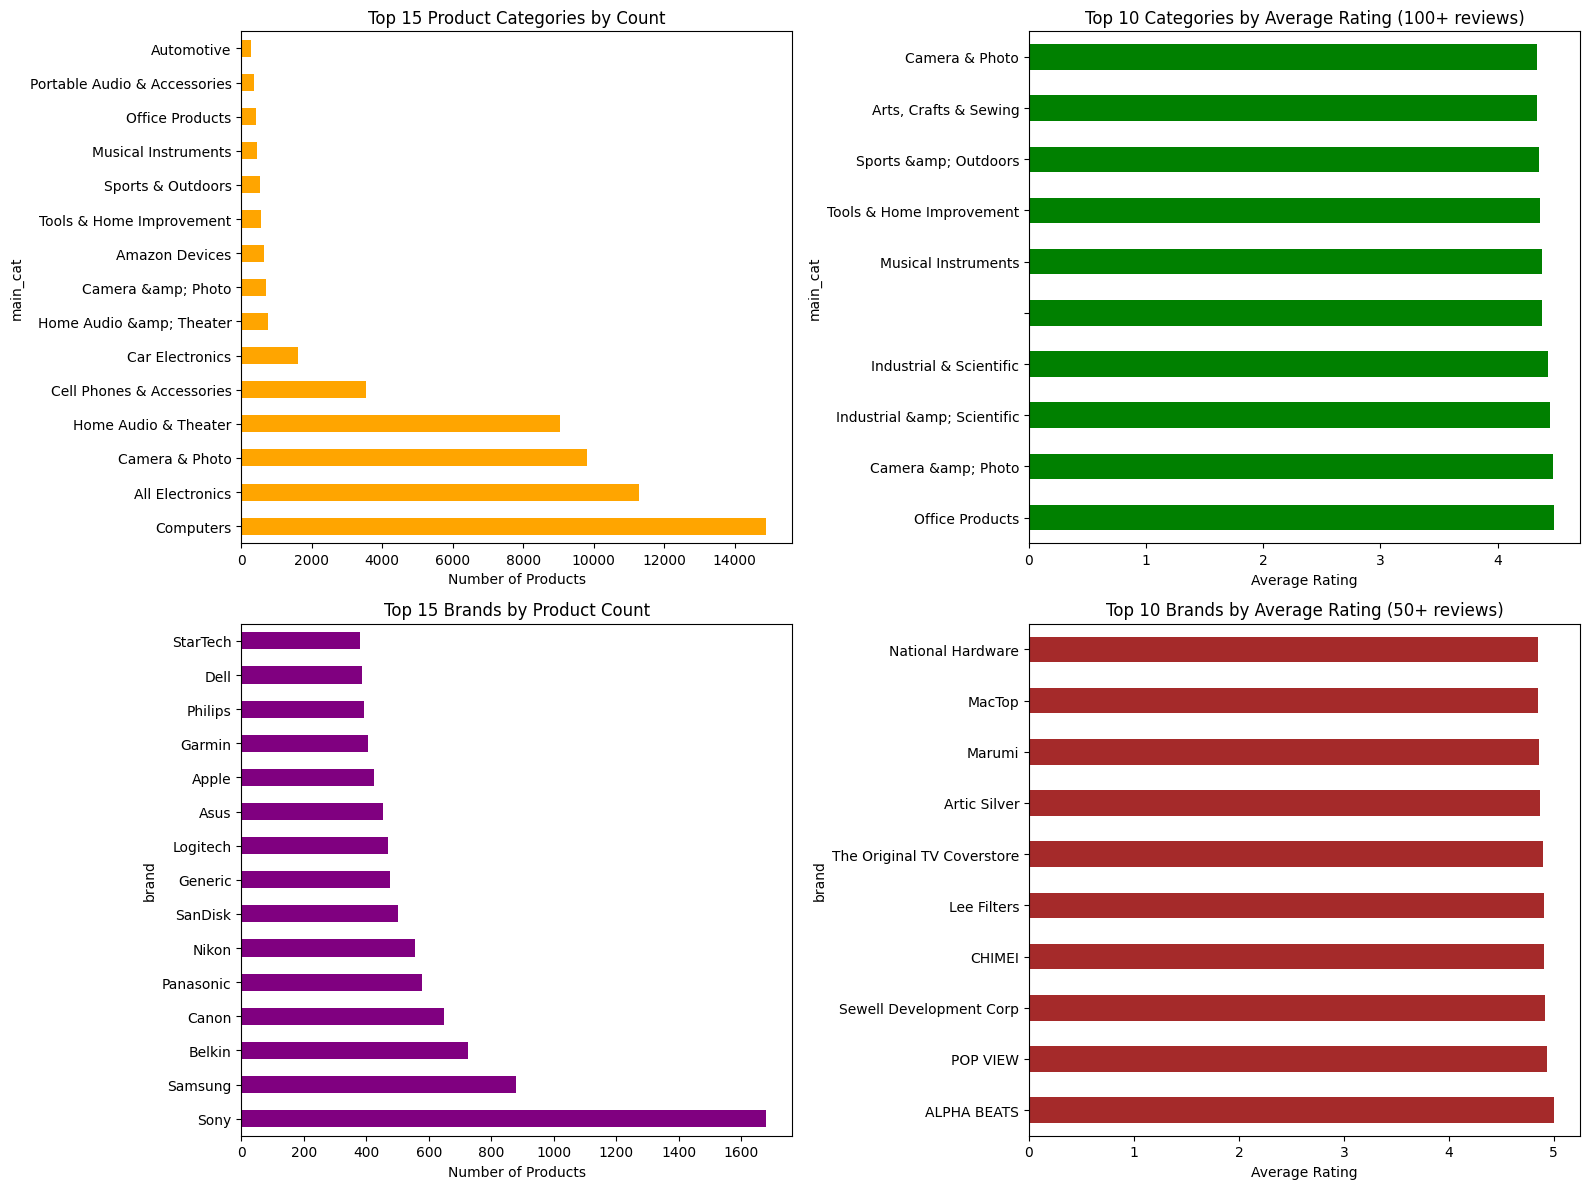

PRODUCT PERFORMANCE INSIGHTS
Products with reviews: 56,445
Products with metadata: 56,370
Metadata coverage: 99.9%

Review Distribution:
Products with 1 review: 0
Products with 2-10 reviews: 19,844
Products with 11-50 reviews: 25,740
Products with 50+ reviews: 11,062

Top 10 Most Reviewed Products:
  B0019HL8Q8: 6,485 reviews - Mediabridge HDMI Cable (10 Feet) Supports 4K@60Hz, High Spee...
  B003L1ZYYW: 6,429 reviews - AmazonBasics High-Speed HDMI Cable - 9.8 Feet (3 Meters) Sup...
  B0019EHU8G: 6,213 reviews - Mediabridge HDMI Cable (6 Feet) Supports 4K@60Hz, High Speed...
  B00DIF2BO2: 4,252 reviews - Cheetah Mounts APFMSB TV Wall Mount Bracket for 20-55&rdquo;...
  B000BQ7GW8: 4,214 reviews - SanDisk 2GB Class 4 SD Flash Memory Card- SDSDB-002G-B35 (La...
  B00004ZCJI: 4,038 reviews - Tiffen 58mm UV Protection Filter...
  B00BWF5U0M: 4,037 reviews - Sabrent 4-Port USB 2.0 Hub with Individual Power Switches an...
  B00009KLAE: 4,036 reviews - Tiffen 43MM UV Protector Filter...
  B00

In [7]:
# Product category and brand performance analysis (using cleaned data)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Category distribution
if 'main_cat' in products_clean.columns:
    category_counts = products_clean['main_cat'].value_counts()
    category_counts.head(15).plot(kind='barh', ax=axes[0,0], color='orange')
    axes[0,0].set_title('Top 15 Product Categories by Count')
    axes[0,0].set_xlabel('Number of Products')
    
    # Category performance by ratings
    category_performance = reviews_clean.merge(products_clean[['asin', 'main_cat']], on='asin', how='inner')
    category_ratings = category_performance.groupby('main_cat').agg({
        'overall': ['mean', 'count']
    }).round(2)
    category_ratings.columns = ['avg_rating', 'review_count']
    
    # Filter categories with significant review volume
    significant_categories = category_ratings[category_ratings['review_count'] >= 100].sort_values('avg_rating', ascending=False)
    significant_categories['avg_rating'].head(10).plot(kind='barh', ax=axes[0,1], color='green')
    axes[0,1].set_title('Top 10 Categories by Average Rating (100+ reviews)')
    axes[0,1].set_xlabel('Average Rating')

# Brand analysis
if 'brand' in products_clean.columns:
    # Clean brand data
    brand_data = products_clean[products_clean['brand'] != 'Unknown']
    if len(brand_data) > 0:
        brand_counts = brand_data['brand'].value_counts()
        brand_counts.head(15).plot(kind='barh', ax=axes[1,0], color='purple')
        axes[1,0].set_title('Top 15 Brands by Product Count')
        axes[1,0].set_xlabel('Number of Products')
        
        # Brand performance
        brand_performance = reviews_clean.merge(products_clean[['asin', 'brand']], on='asin', how='inner')
        brand_performance = brand_performance[brand_performance['brand'] != 'Unknown']
        brand_ratings = brand_performance.groupby('brand').agg({
            'overall': ['mean', 'count']
        }).round(2)
        brand_ratings.columns = ['avg_rating', 'review_count']
        
        # Top performing brands with significant volume
        top_brands = brand_ratings[brand_ratings['review_count'] >= 50].sort_values('avg_rating', ascending=False)
        top_brands['avg_rating'].head(10).plot(kind='barh', ax=axes[1,1], color='brown')
        axes[1,1].set_title('Top 10 Brands by Average Rating (50+ reviews)')
        axes[1,1].set_xlabel('Average Rating')
    else:
        axes[1,0].text(0.5, 0.5, 'No brand data available', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,1].text(0.5, 0.5, 'No brand data available', ha='center', va='center', transform=axes[1,1].transAxes)

plt.tight_layout()
plt.show()

# Product performance metrics
print("PRODUCT PERFORMANCE INSIGHTS")
print("="*50)

# Overall metrics
products_with_reviews = reviews_clean['asin'].nunique()
products_with_metadata = products_clean.shape[0]
print(f"Products with reviews: {products_with_reviews:,}")
print(f"Products with metadata: {products_with_metadata:,}")
print(f"Metadata coverage: {(products_with_metadata/products_with_reviews*100):.1f}%")

# Review concentration
product_review_counts = reviews_clean['asin'].value_counts()
print(f"\nReview Distribution:")
print(f"Products with 1 review: {(product_review_counts == 1).sum():,}")
print(f"Products with 2-10 reviews: {((product_review_counts >= 2) & (product_review_counts <= 10)).sum():,}")
print(f"Products with 11-50 reviews: {((product_review_counts >= 11) & (product_review_counts <= 50)).sum():,}")
print(f"Products with 50+ reviews: {(product_review_counts >= 50).sum():,}")

print(f"\nTop 10 Most Reviewed Products:")
top_products = product_review_counts.head(10)
for asin, count in top_products.items():
    product_name = products_clean[products_clean['asin'] == asin]['title'].iloc[0] if asin in products_clean['asin'].values else 'Unknown'
    print(f"  {asin}: {count:,} reviews - {product_name[:60]}...")

# Category insights
if 'main_cat' in products_clean.columns:
    print(f"\nCategory Performance:")
    print(f"Total categories: {products_clean['main_cat'].nunique()}")
    print(f"Categories with 100+ products: {(category_counts >= 100).sum()}")
    
    if 'category_performance' in locals():
        print(f"\nTop 5 Categories by Review Volume:")
        top_category_volume = category_ratings.sort_values('review_count', ascending=False).head(5)
        for cat, row in top_category_volume.iterrows():
            print(f"  {cat}: {row['review_count']:,} reviews, {row['avg_rating']:.2f} avg rating")

- **Catalog completeness:** Excellent **99.9% metadata coverage** ensures strong alignment between reviews and product attributes.  
- **Engagement spread:** Majority of products have **2–50 reviews**, while only **20% exceed 50 reviews**, showing a long-tail distribution common in marketplaces.  
- **Top products:** Highly reviewed items are dominated by **tech accessories (HDMI cables, memory cards, USB hubs)**, highlighting strong subcategory concentration.  
- **Category dynamics:** **Electronics-related segments** (Computers, Camera & Photo, Home Audio) drive the bulk of review volume, with consistently high **average ratings around 4.3**, suggesting both popularity and customer satisfaction.  

### Brand Analysis for User-Brand Features

Understanding brand preferences and user-brand interactions for personalized recommendations.

In [8]:
# Simple Brand Analysis for User-Brand Features
print("BRAND ANALYSIS FOR RECOMMENDATION SYSTEM")
print("="*50)

if 'brand' in products_clean.columns:
    # Merge reviews with brand data
    reviews_with_brands = reviews_clean.merge(products_clean[['asin', 'brand']], on='asin', how='inner')
    reviews_with_brands = reviews_with_brands[reviews_with_brands['brand'] != 'Unknown']
    
    if len(reviews_with_brands) > 0:
        print(f"Reviews with brand information: {len(reviews_with_brands):,} ({len(reviews_with_brands)/len(reviews_clean)*100:.1f}%)")
        print(f"Unique brands: {reviews_with_brands['brand'].nunique():,}")
        
        # User-brand interaction patterns
        user_brand_counts = reviews_with_brands.groupby('reviewerid')['brand'].nunique()
        
        print(f"\nUser Brand Diversity:")
        print(f"Users who reviewed 1 brand: {(user_brand_counts == 1).sum():,} ({(user_brand_counts == 1).mean()*100:.1f}%)")
        print(f"Users who reviewed 2-5 brands: {((user_brand_counts >= 2) & (user_brand_counts <= 5)).sum():,} ({((user_brand_counts >= 2) & (user_brand_counts <= 5)).mean()*100:.1f}%)")
        print(f"Users who reviewed 6+ brands: {(user_brand_counts >= 6).sum():,} ({(user_brand_counts >= 6).mean()*100:.1f}%)")
        print(f"Average brands per user: {user_brand_counts.mean():.1f}")
        
        # Brand loyalty analysis
        user_brand_loyalty = reviews_with_brands.groupby('reviewerid').apply(
            lambda x: x['brand'].value_counts().iloc[0] / len(x) if len(x) > 0 else 0
        )
        
        print(f"\nBrand Loyalty Patterns:")
        print(f"High loyalty (>80% same brand): {(user_brand_loyalty > 0.8).sum():,} users")
        print(f"Medium loyalty (50-80% same brand): {((user_brand_loyalty >= 0.5) & (user_brand_loyalty <= 0.8)).sum():,} users") 
        print(f"Low loyalty (<50% same brand): {(user_brand_loyalty < 0.5).sum():,} users")
        
        # Top brands by user engagement
        brand_user_engagement = reviews_with_brands.groupby('brand').agg({
            'reviewerid': 'nunique',
            'overall': ['count', 'mean']
        }).round(2)
        brand_user_engagement.columns = ['unique_users', 'total_reviews', 'avg_rating']
        brand_user_engagement = brand_user_engagement.sort_values('unique_users', ascending=False)
        
        print(f"\nTop 10 Brands by User Engagement:")
        for brand, row in brand_user_engagement.head(10).iterrows():
            print(f"  {brand}: {row['unique_users']:,} users, {row['total_reviews']:,} reviews, {row['avg_rating']:.2f} rating")
        
        print(f"\nUSER-BRAND FEATURES READY:")
        print(f"Brand diversity patterns identified")
        print(f"Brand loyalty metrics calculated") 
        print(f"User-brand preferences available for personalization")
        
    else:
        print("No brand data available for analysis")
else:
    print("Brand column not found in products dataset")

BRAND ANALYSIS FOR RECOMMENDATION SYSTEM
Reviews with brand information: 2,715,313 (99.8%)
Unique brands: 7,139

User Brand Diversity:
Users who reviewed 1 brand: 533 (0.2%)
Users who reviewed 2-5 brands: 151,548 (45.2%)
Users who reviewed 6+ brands: 182,843 (54.6%)
Average brands per user: 7.2


C:\Users\Noura\AppData\Local\Temp\ipykernel_28696\1965884416.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_brand_loyalty = reviews_with_brands.groupby('reviewerid').apply(



Brand Loyalty Patterns:
High loyalty (>80% same brand): 723 users
Medium loyalty (50-80% same brand): 18,046 users
Low loyalty (<50% same brand): 316,155 users

Top 10 Brands by User Engagement:
  Logitech: 57,855.0 users, 72,939.0 reviews, 4.25 rating
  Sony: 53,570.0 users, 73,064.0 reviews, 4.26 rating
  SanDisk: 45,854.0 users, 56,649.0 reviews, 4.53 rating
  AmazonBasics: 44,340.0 users, 53,337.0 reviews, 4.53 rating
  Samsung: 34,758.0 users, 40,545.0 reviews, 4.31 rating
  Belkin: 33,180.0 users, 41,567.0 reviews, 4.30 rating
  Western Digital: 30,189.0 users, 35,686.0 reviews, 4.37 rating
  Canon: 28,488.0 users, 44,195.0 reviews, 4.50 rating
  Asus: 24,444.0 users, 28,312.0 reviews, 4.23 rating
  StarTech: 21,902.0 users, 27,153.0 reviews, 4.43 rating

USER-BRAND FEATURES READY:
Brand diversity patterns identified
Brand loyalty metrics calculated
User-brand preferences available for personalization



- **Loyalty distribution:** Majority of users show **low brand loyalty (≈94%)**, indicating that cross-brand shopping is highly common.  
- **Core loyal base:** Around **700 users** consistently buy from the same brand, representing strong niche loyalty segments.  
- **Engagement leaders:** **Logitech, Sony, SanDisk, and AmazonBasics** dominate user engagement, collectively driving the highest review volumes.  
- **Satisfaction consistency:** Top brands maintain **high average ratings (4.3–4.5)**, suggesting strong perceived reliability and trust among frequent buyers.  









## 4. Review Quality & Text Analysis

REVIEW QUALITY & TEXT ANALYSIS - KEY INSIGHTS
Total Reviews: 2,721,300

RATING INSIGHTS:
  Average Rating: 4.30/5.0
  Median Rating: 5.0/5.0
  Rating Std Dev: 1.16

RATING DISTRIBUTION:
  5 stars: 1,748,443 ( 64.3%)
  4 stars:  485,185 ( 17.8%)
  3 stars:  205,436 (  7.5%)
  2 stars:  117,004 (  4.3%)
  1 stars:  165,232 (  6.1%)

BUSINESS QUALITY INDICATORS:
  Positive Reviews (4-5 stars): 2,233,628 (82.1%)
  Negative Reviews (1-2 stars): 282,236 (10.4%)
  Satisfaction Score: 82.1%
  Reviews with Summary: 2,721,097 (100.0%)


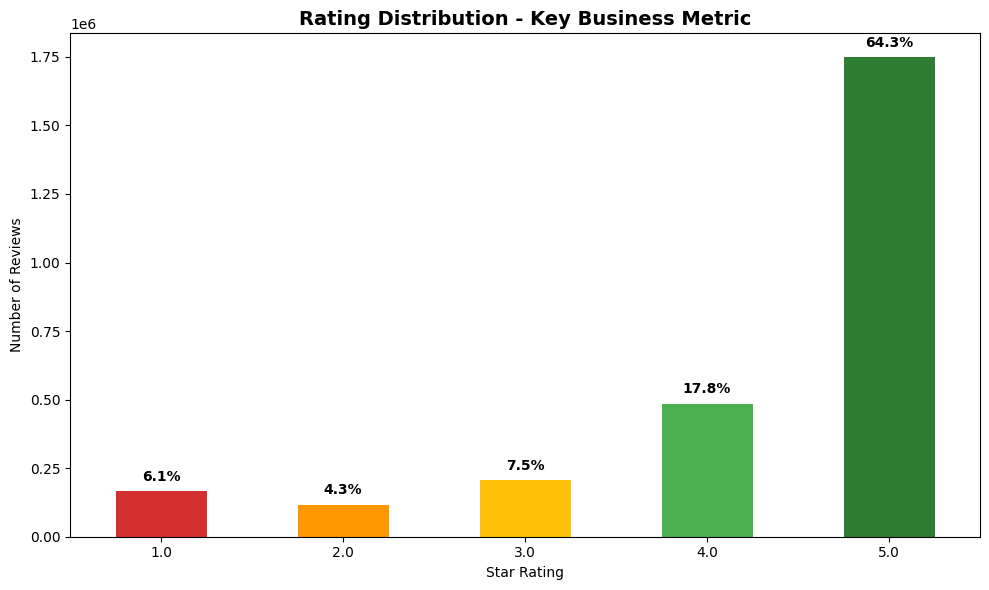

In [6]:
# Review Quality & Text Analysis - Key Business Insights (Optimized)
print("REVIEW QUALITY & TEXT ANALYSIS - KEY INSIGHTS")
print("="*60)

# Core metrics - fast calculations
total_reviews = len(reviews_clean)
print(f"Total Reviews: {total_reviews:,}")

# Rating distribution - most important business metric
rating_stats = reviews_clean['overall'].describe()
rating_dist = reviews_clean['overall'].value_counts().sort_index()

print(f"\nRATING INSIGHTS:")
print(f"  Average Rating: {rating_stats['mean']:.2f}/5.0")
print(f"  Median Rating: {rating_stats['50%']:.1f}/5.0")
print(f"  Rating Std Dev: {rating_stats['std']:.2f}")

print(f"\nRATING DISTRIBUTION:")
for rating in [5, 4, 3, 2, 1]:  # Start with highest for business focus
    count = rating_dist.get(rating, 0)
    pct = count/total_reviews*100
    print(f"  {rating} stars: {count:>8,} ({pct:>5.1f}%)")

# Business-critical quality indicators
print(f"\nBUSINESS QUALITY INDICATORS:")
excellent_reviews = rating_dist.get(5, 0) + rating_dist.get(4, 0)
poor_reviews = rating_dist.get(1, 0) + rating_dist.get(2, 0)
print(f"  Positive Reviews (4-5 stars): {excellent_reviews:,} ({excellent_reviews/total_reviews*100:.1f}%)")
print(f"  Negative Reviews (1-2 stars): {poor_reviews:,} ({poor_reviews/total_reviews*100:.1f}%)")
print(f"  Satisfaction Score: {excellent_reviews/total_reviews*100:.1f}%")

# Summary completeness
if 'summary_length' in reviews_clean.columns:
    reviews_with_summary = (reviews_clean['summary_length'] > 0).sum()
    print(f"  Reviews with Summary: {reviews_with_summary:,} ({reviews_with_summary/total_reviews*100:.1f}%)")

# Quick visualization - only most important chart
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Rating distribution bar chart
colors = ['#d32f2f', '#ff9800', '#ffc107', '#4caf50', '#2e7d32']  # Red to Green
rating_dist.plot(kind='bar', ax=ax, color=colors)
ax.set_title('Rating Distribution - Key Business Metric', fontsize=14, fontweight='bold')
ax.set_xlabel('Star Rating')
ax.set_ylabel('Number of Reviews')
ax.tick_params(axis='x', rotation=0)

# Add percentage labels on bars
for i, (rating, count) in enumerate(rating_dist.items()):
    pct = count/total_reviews*100
    ax.text(i, count + total_reviews*0.01, f'{pct:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



- **Customer satisfaction is high** — 82.1% of all reviews are 4★ or 5★, with a strong overall average rating of **4.3/5**.  
- **Feedback polarity is positive-skewed**, as nearly **two-thirds (64%)** of all ratings are 5, indicating strong approval bias.  
- **Low dissatisfaction share** — only **10.4%** of reviews are negative (1–2), suggesting consistent product performance and experience.  
- **Review completeness is excellent**, with nearly **100% containing summaries**, providing reliable textual signals for sentiment analysis and NLP-based insights.

## 5. Temporal Patterns Analysis

C:\Users\Noura\AppData\Local\Temp\ipykernel_28696\1967020536.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  reviews_clean['review_date'] = pd.to_datetime(reviews_clean['unixreviewtime'], unit='s')


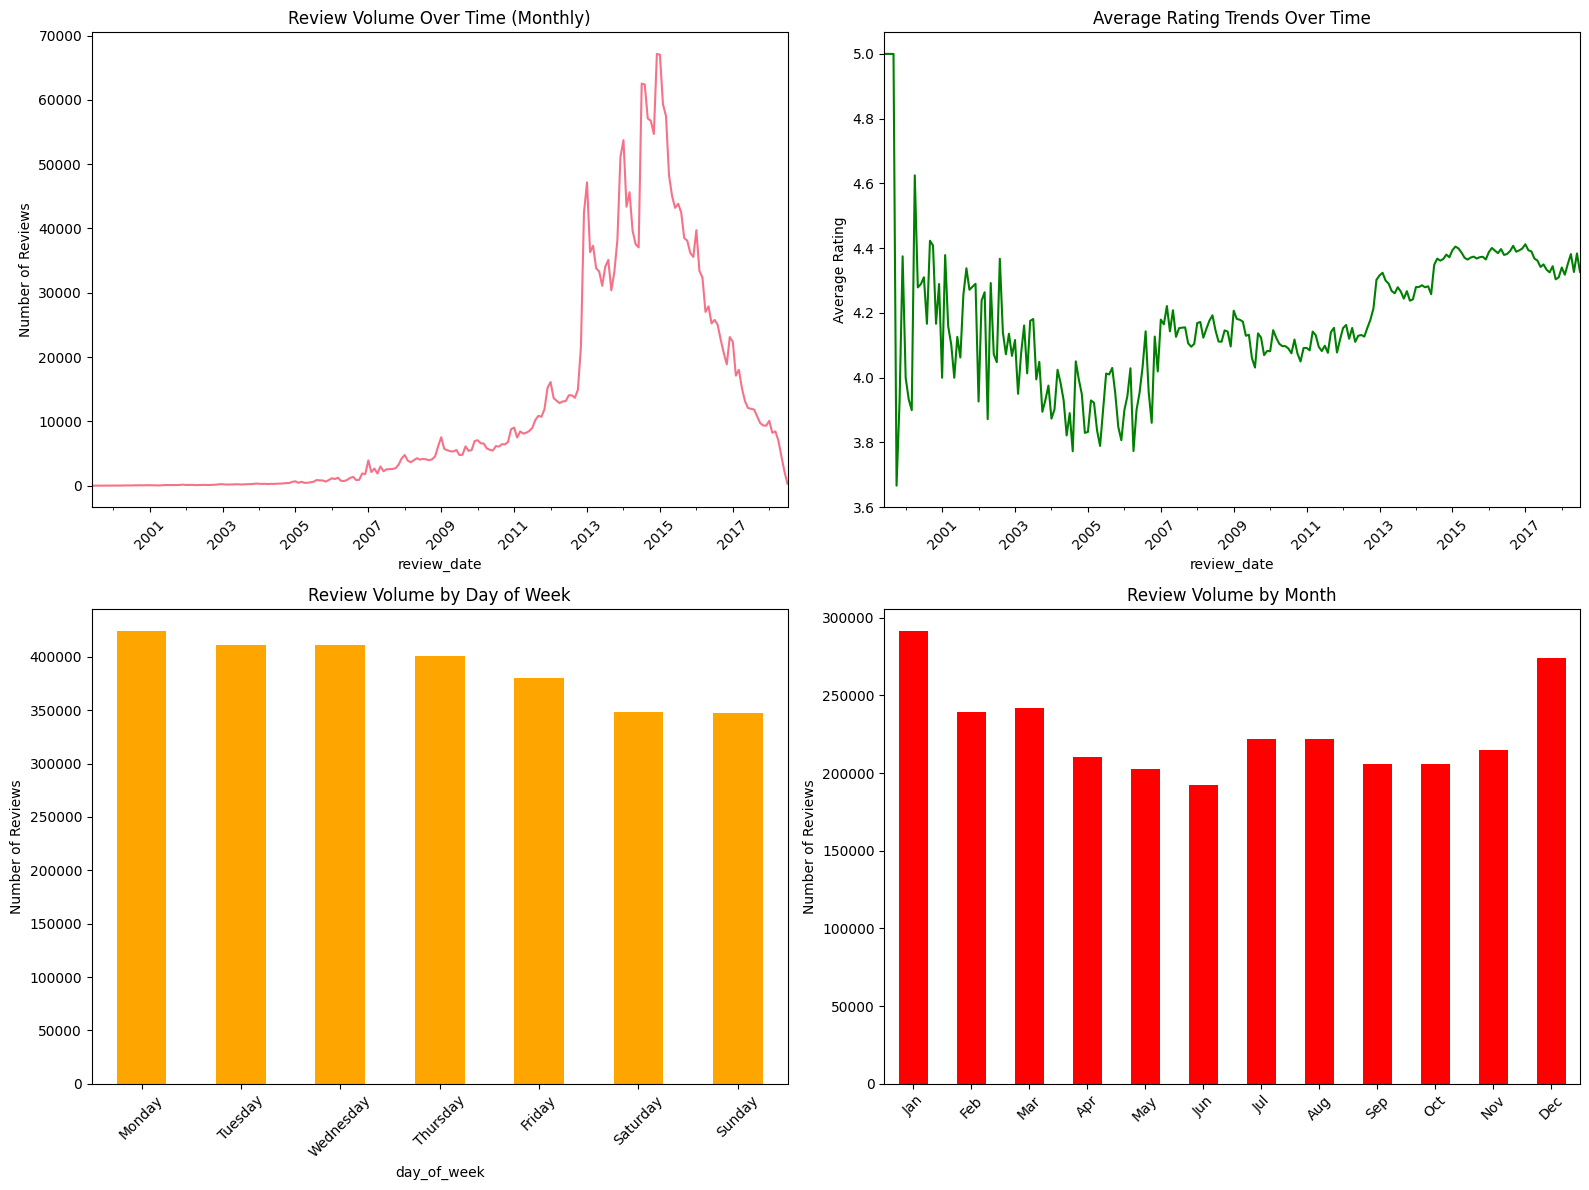

TEMPORAL PATTERN INSIGHTS
Date range: 1999-06-13 to 2018-07-24
Time span: 6981 days
Peak review month: 2014-12 (67,153 reviews)
Peak review day: Monday (423,724 reviews)

Seasonal Patterns:
Q1 (Jan-Mar): 772,229 reviews (28.4%)
Q2 (Apr-Jun): 605,494 reviews (22.3%)
Q3 (Jul-Sep): 649,160 reviews (23.9%)
Q4 (Oct-Dec): 694,417 reviews (25.5%)

Rating Trends:
Rating trend: ↑ 0.122 points over time period
Most recent month avg rating: 4.33
Highest monthly avg rating: 5.00 (1999-06)


In [9]:
# Temporal patterns analysis (using cleaned data)
if 'unixreviewtime' in reviews_clean.columns:
    # Convert unix timestamp to datetime
    reviews_clean['review_date'] = pd.to_datetime(reviews_clean['unixreviewtime'], unit='s')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Review volume over time
    monthly_volume = reviews_clean.groupby(reviews_clean['review_date'].dt.to_period('M')).size()
    monthly_volume.plot(ax=axes[0,0])
    axes[0,0].set_title('Review Volume Over Time (Monthly)')
    axes[0,0].set_ylabel('Number of Reviews')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Average rating trends
    monthly_rating = reviews_clean.groupby(reviews_clean['review_date'].dt.to_period('M'))['overall'].mean()
    monthly_rating.plot(ax=axes[0,1], color='green')
    axes[0,1].set_title('Average Rating Trends Over Time')
    axes[0,1].set_ylabel('Average Rating')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Day of week patterns
    reviews_clean['day_of_week'] = reviews_clean['review_date'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_volume = reviews_clean['day_of_week'].value_counts().reindex(day_order)
    daily_volume.plot(kind='bar', ax=axes[1,0], color='orange')
    axes[1,0].set_title('Review Volume by Day of Week')
    axes[1,0].set_ylabel('Number of Reviews')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Seasonal patterns
    reviews_clean['month'] = reviews_clean['review_date'].dt.month
    monthly_pattern = reviews_clean['month'].value_counts().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_pattern.index = [month_names[i-1] for i in monthly_pattern.index]
    monthly_pattern.plot(kind='bar', ax=axes[1,1], color='red')
    axes[1,1].set_title('Review Volume by Month')
    axes[1,1].set_ylabel('Number of Reviews')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Temporal insights
    print("TEMPORAL PATTERN INSIGHTS")
    print("="*50)
    
    date_range = reviews_clean['review_date'].agg(['min', 'max'])
    print(f"Date range: {date_range['min'].strftime('%Y-%m-%d')} to {date_range['max'].strftime('%Y-%m-%d')}")
    print(f"Time span: {(date_range['max'] - date_range['min']).days} days")
    
    # Peak periods
    peak_month = monthly_volume.idxmax()
    peak_day = daily_volume.idxmax()
    print(f"Peak review month: {peak_month} ({monthly_volume.max():,} reviews)")
    print(f"Peak review day: {peak_day} ({daily_volume.max():,} reviews)")
    
    # Seasonal analysis (using numeric month values)
    print(f"\nSeasonal Patterns:")
    month_nums = reviews_clean['review_date'].dt.month
    q1_reviews = reviews_clean[month_nums.isin([1,2,3])].shape[0]
    q2_reviews = reviews_clean[month_nums.isin([4,5,6])].shape[0]
    q3_reviews = reviews_clean[month_nums.isin([7,8,9])].shape[0]
    q4_reviews = reviews_clean[month_nums.isin([10,11,12])].shape[0]
    
    print(f"Q1 (Jan-Mar): {q1_reviews:,} reviews ({q1_reviews/len(reviews_clean)*100:.1f}%)")
    print(f"Q2 (Apr-Jun): {q2_reviews:,} reviews ({q2_reviews/len(reviews_clean)*100:.1f}%)")
    print(f"Q3 (Jul-Sep): {q3_reviews:,} reviews ({q3_reviews/len(reviews_clean)*100:.1f}%)")
    print(f"Q4 (Oct-Dec): {q4_reviews:,} reviews ({q4_reviews/len(reviews_clean)*100:.1f}%)")
    
    # Rating trends
    print(f"\nRating Trends:")
    yearly_ratings = reviews_clean.groupby(reviews_clean['review_date'].dt.year)['overall'].mean()
    if len(yearly_ratings) > 1:
        rating_trend = yearly_ratings.iloc[-1] - yearly_ratings.iloc[0]
        print(f"Rating trend: {'↑' if rating_trend > 0 else '↓'} {abs(rating_trend):.3f} points over time period")
    
    print(f"Most recent month avg rating: {monthly_rating.iloc[-1]:.2f}")
    print(f"Highest monthly avg rating: {monthly_rating.max():.2f} ({monthly_rating.idxmax()})")
    
else:
    print("No temporal data available in the dataset")
    print("Cannot perform time-based analysis without date/time information")

# 6. Correlation analysis and interaction insights

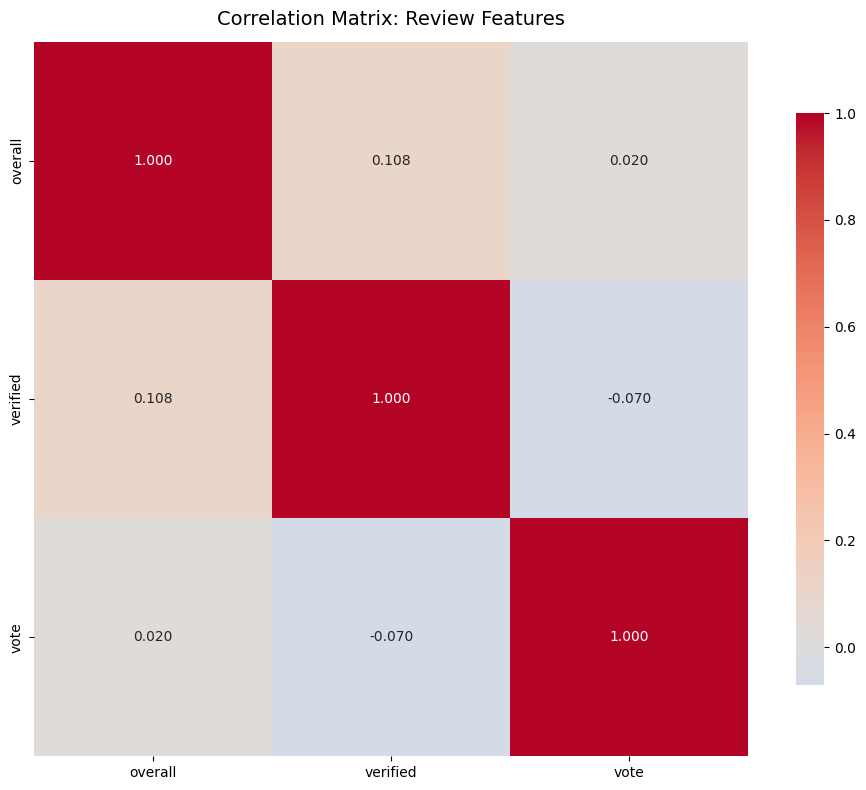

Correlation with Overall Rating:
  verified: 0.108
  vote: 0.020


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select only existing numerical columns for correlation
available_cols = ['overall', 'verified', 'vote']
existing_cols = [col for col in available_cols if col in reviews_clean.columns]
correlation_data = reviews_clean[existing_cols].copy()

# --- Data cleaning and type conversions ---

# Clean "vote" column: remove commas and convert safely to numeric
if 'vote' in correlation_data.columns:
    correlation_data['vote'] = (
        correlation_data['vote']
        .astype(str)
        .str.replace(',', '', regex=False)
        .replace(['None', 'none', 'nan', 'NaN', ''], pd.NA)
    )
    # Convert safely to float, coercing invalid strings to NaN
    correlation_data['vote'] = pd.to_numeric(correlation_data['vote'], errors='coerce')

# Convert "verified" column to numeric (1 for True, 0 for False)
if 'verified' in correlation_data.columns:
    correlation_data['verified'] = (
        correlation_data['verified']
        .astype(str)
        .str.lower()
        .isin(['true', '1'])
        .astype(int)
    )

# Drop rows where all selected columns are NaN
correlation_data = correlation_data.dropna(how='all')

# --- Correlation Matrix ---
correlation_matrix = correlation_data.corr(numeric_only=True)

# --- Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix: Review Features', fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# --- Correlation with Overall Rating ---
print("Correlation with Overall Rating:")
if 'overall' in correlation_matrix.columns:
    correlations_with_rating = correlation_matrix['overall'].sort_values(ascending=False)
    for feature, corr in correlations_with_rating.items():
        if feature != 'overall':
            print(f"  {feature}: {corr:.3f}")
else:
    print("  'overall' column not available in correlation matrix.")

### Insights from Correlation Analysis

- **Verified vs Overall (0.108):** Verified purchases show a mild positive correlation with higher ratings, suggesting authenticity may slightly influence satisfaction.  
- **Vote vs Overall (0.020):** The number of votes on a review has almost no relationship with the rating, indicating community engagement doesn’t reflect sentiment strength.  
- **Verified vs Vote (-0.070):** Verified reviews are slightly less likely to receive higher votes, implying voting behavior may be more about visibility than purchase validation.  
- **Overall Interpretation:** Review behavior is primarily driven by **product satisfaction** rather than external factors such as verification or popularity.


#### Key Business Insights
- **Strong customer satisfaction:** With **82% positive reviews** and an **average rating of 4.3**, the marketplace demonstrates high product trust and consistent buyer satisfaction.  
- **Highly engaged ecosystem:** Over **2.7M reviews** from **335K active users** indicate a healthy feedback culture — a strong foundation for personalization and trust-based recommendations.  
- **Dominant product segments:** **Computers, Electronics, and Camera & Photo** categories account for most reviews, highlighting where to focus marketing and product diversification efforts.  
- **Brand-driven engagement:** A few brands (e.g., **Logitech, Sony, SanDisk, AmazonBasics**) dominate user attention — opportunities exist for partnerships and exclusive promotions.  
- **Seasonality patterns:** Peak review activity in **Q1 and Q4** suggests aligning marketing pushes and inventory around post-holiday demand and year-end sales cycles.  
- **Low loyalty but broad exploration:** Most users exhibit **low brand loyalty**, indicating a competitive market but also an opportunity to influence repurchase through personalization.

#### Strategic Recommendations
1. **Launch a personalized merchant recommendation system** to retain low-loyalty customers by surfacing trusted or similar brands based on user behavior.  
2. **Prioritize Q1 and Q4 marketing campaigns**, leveraging high review activity to boost sales and collect richer customer feedback.  
3. **Invest in top-performing categories** (Electronics, Computers, Camera & Photo) with bundled deals or curated experiences to drive higher engagement.  
4. **Enhance brand visibility for emerging merchants** — use sentiment and engagement metrics to highlight rising, high-rated brands.  
5. **Monitor rating shifts and anomalies** to proactively identify product quality or service issues before they escalate.  
6. **Leverage textual review data** (summaries and review text) for sentiment and keyword extraction to better understand evolving customer needs.  